# Neo4j data loading setup
Using neo4j, we’ll load in twitter data to create a network showing the relationships between legislators’ tweets, other users they mention, and hashtags they mention. 

***

`NOTEBOOK SETUP`
- Create a .py file containing the following declarations and place it in the same directory as this notebook
    - password = `Your neo4j server password`
    - NEO4J_DATA_DIR = `C:/Users/PC USERNAME/AppData/Local/Neo4j/Relate/Data/dbmss/SERVER ID/import/data/`
- Place the legislator dataset into the above NEO4J_DATA_DIR
- Set the ROOT_DIR directory to reflect where this notebook is in relation to the project root

***

### Import Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd 
import numpy as np 
from urllib.request import urlopen
import redis
import json
import pysolr
import requests
import datetime

In [3]:
import sys
import os

In [4]:
ROOT_DIR = "../../"
DATA_DIR = ROOT_DIR + "data/"

In [5]:
# Load utils
sys.path.insert(0, os.path.abspath(ROOT_DIR + "/src"))
from utils import *

### Import local password and NEO4J_DATA_DIR

In [6]:
from pword import *

### Connect to local neo4j database

In [7]:
from neo4j import GraphDatabase
uri = 'neo4j://localhost:7687'
driver = GraphDatabase.driver(uri, auth=("neo4j", password))
session = driver.session()

***

# Data loading + processing

In [8]:
legislators_fname = DATA_DIR + "legislators-current.csv"
full_tweets_fname = DATA_DIR + "tweets.json"
tweets_fname = NEO4J_DATA_DIR + "legis_tweets.csv"

### Load legislators

In [9]:
legis_df = pd.read_csv(legislators_fname)

In [10]:
legis_df.head()

,last_name,first_name,middle_name,suffix,nickname,full_name,birthday,gender,type,state,...,opensecrets_id,lis_id,fec_ids,cspan_id,govtrack_id,votesmart_id,ballotpedia_id,washington_post_id,icpsr_id,wikipedia_id
0,Brown,Sherrod,NaN,NaN,NaN,Sherrod Brown,1952-11-09,M,sen,OH,...,N00003535,S307,"H2OH13033,S6OH00163",5051.0,400050,27018.0,Sherrod Brown,NaN,29389.0,Sherrod Brown
1,Cantwell,Maria,NaN,NaN,NaN,Maria Cantwell,1958-10-13,F,sen,WA,...,N00007836,S275,"S8WA00194,H2WA01054",26137.0,300018,27122.0,Maria Cantwell,NaN,39310.0,Maria Cantwell
2,Cardin,Benjamin,L.,NaN,NaN,Benjamin L. Cardin,1943-10-05,M,sen,MD,...,N00001955,S308,"H6MD03177,S6MD03177",4004.0,400064,26888.0,Ben Cardin,NaN,15408.0,Ben Cardin
3,Carper,Thomas,Richard,NaN,NaN,Thomas R. Carper,1947-01-23,M,sen,DE,...,N00012508,S277,S8DE00079,663.0,300019,22421.0,Tom Carper,NaN,15015.0,Tom Carper
4,Casey,Robert,P.,Jr.,Bob,"Robert P. Casey, Jr.",1960-04-13,M,sen,PA,...,N00027503,S309,S6PA00217,47036.0,412246,2541.0,"Bob Casey, Jr.",NaN,40703.0,Bob Casey Jr.


### Create tweets subset for only legislators present in the dataset

In [11]:
def date_convert(dt):
    """Convert pandas datetime object to neo4j date string representation"""
    return f"{dt.year}-{dt.month}-{dt.day}"

In [11]:
legis_tweets = []
legislator_names = set(legis_df.twitter.unique())
loaded_rows = 0

for chunk in pd.read_json(full_tweets_fname, lines=True, chunksize=1000):
    loaded_rows += chunk.shape[0]
    print(f"Processed {loaded_rows} rows", end='\r')
    for row in range(chunk.shape[0]):
        replier = chunk.iloc[row].screen_name
        repliee = chunk.iloc[row].in_reply_to_screen_name
        if replier in legislator_names and repliee in legislator_names:
            row = chunk.iloc[row].to_dict()
            # Remove all single and double quotes from text
            row["text"] = row["text"].replace('\'', '').replace("\"", "").replace('’', '').replace('\\', '/')
            # Add a hashtag key
            row["htags"] = row["entities"]["hashtags"]
            # Add a user_mentions key
            row["user_mentions"] = row["entities"]["user_mentions"]
            # Change created date to be default neo4j compatible
            row["created_at"] = date_convert(row["created_at"])
            
            legis_tweets.append(row)

In [13]:
legis_tweets_df = pd.DataFrame(legis_tweets)

In [14]:
legis_tweets_df.shape

(14988, 34)

In [18]:
legis_tweets_df.to_csv(tweets_fname, index=False)

***

# Neo4j data loading

### Load legislators into neo4j

In [68]:
q = """
WITH \"file:///""" + legislators_fname + """\" AS url
LOAD CSV WITH HEADERS FROM url AS row

CREATE (p:Person {fname:row.first_name, lname:row.last_name, full_name:row.full_name, twitter:row.twitter, party:row.party, state:row.state})

RETURN p
"""
out = session.run(q)
out.data()

### Load tweets into neo4j

In [20]:
def upload_chunk(fname):
    q = """
    WITH \"file:///""" + fname + """\" AS url
    LOAD CSV WITH HEADERS FROM url AS row
    
    WITH row WHERE NOT row.in_reply_to_screen_name IS NULL
    
    MERGE (p1:Person {twitter:row.screen_name})
    MERGE (p2:Person {twitter:row.in_reply_to_screen_name})
        
    CREATE (p1) - [r:REPLIED] -> (p2)
    
    SET r.create_date = date(row.created_at)
    SET r.text = row.text
    
    RETURN r
    """
    out = session.run(q)
    
    return out.data()

In [21]:
chunk_num = 0
rows_uploaded = 0
# NEO4J_DATA_DIR is defined in pword.py, stored in the same directory as this notebook.
if not os.path.exists(NEO4J_DATA_DIR + "temp/"):
    os.mkdir(NEO4J_DATA_DIR + "temp/")

for chunk in pd.read_csv(tweets_fname, chunksize=10000):
    fname = "temp/" + f"tweets_chunk_{chunk_num}.csv"
    print(" "*50, end='\r')
    print("Saving temp file", end='\r')
    chunk.to_csv(NEO4J_DATA_DIR + fname, index=False)
    print(" "*50, end='\r')
    print(f"Uploading chunk {chunk_num} data", end='\r')
    upload_chunk(DATA_DIR + fname)
    print(" "*50, end='\r')
    print("Removing temp file", end='\r')
    os.remove(NEO4J_DATA_DIR + fname)
    
    chunk_num += 1
    rows_uploaded += chunk.shape[0]
    
print("Tweet upload complete")
print(f"{chunk_num + 1} chunks processed")
print(f"{rows_uploaded} rows uploaded")

Tweet upload complete                             
3 chunks processed
14988 rows uploaded


***

# Analysis

### Party distribution between a `timedelta` day period

In [12]:
def get_date_range(in_date, out_date=None, time_delta=30):
    in_date = datetime.datetime.strptime(in_date, "%Y-%m-%d")
    if out_date is None:
        out_date = in_date + datetime.timedelta(days=time_delta)
    date_range = list(map(date_convert, [in_date, out_date]))
    
    return date_range

In [13]:
def get_bounded_data(in_date, out_date=None, time_delta=30):
    date_range = get_date_range(in_date, out_date, time_delta)
    
    q = """
    MATCH (p1:Person) - [r:REPLIED] -> (p2:Person)
    WHERE r.create_date > DATE(\"""" + date_range[0] + """\") AND r.create_date < DATE(\"""" + date_range[1] + """\")
    RETURN p1, r.text, p2
    """
    print("Running neo4j query:\n" + q)
    out = session.run(q)
    
    return out.data()

In [14]:
from collections import defaultdict

In [15]:
def get_party_dist(data):
    party_count = defaultdict(int)
    for elem in data:
        party_count[elem["p1"]["party"]] += 1
        party_count[elem["p2"]["party"]] += 1
    return party_count

In [16]:
def plot_party_dist(in_date, data, figsize=(10, 10)):
    display(data)
    title = get_date_range(in_date)
    title = "Party distribution of " + title[0] + ' to ' + title[1] + " tweets"
    data.plot(y="count", kind="pie", figsize=figsize, title=title)

***

# Redis Caching

In [18]:
import redis
r = redis.Redis(host='my-redis', port=6379, db=0)
## Test redis system functionality
r.set('foo', 'bar')

In [17]:
def solr_query(string):
    """Function that takes in string of Queries and formats into solr query JSON
    
    Args: 
        param1(str): string of space separated queries
        ex1: "trump"
        ex2: "trump biden"
        
    Returns: 
        string: link of solr query output
    """
    
    link = 'http://awesome-hw.sdsc.edu:8983/solr/student-news/select?q='
    column = 'title%3A'
    space = '%20AND%20'
    searches = string.split(" ")
    multiple = ''
    
    #If there is only one search 
    if len(searches) == 1:
        link = link + column + searches[0]
    #Multiple searches to concatenate
    else:
        for i in range(1, len(searches)):
            multiple = multiple + space + column + searches[i]
        link = link + column + searches[0] + multiple
        
    return link

In [60]:
## Solr query
SOLR_QUERY = solr_query("trump election")

q1j = requests.get(SOLR_QUERY)
out = q1j.json()

In [20]:
def format_response(response):
    """Format query output into a dictionary"""
    out = {}
    out["title"] = response["text-field"]
    out["publishdate"] = response["publishdate"]
    return out

output = list(map(format_response, out["response"]["docs"]))

In [21]:
## Put publish date and title of article into Redis Cache

for out in output: 
    r.append(out['publishdate'], out['title'])

In [22]:
## Create Redis pipeline to get needed values 

pipe = r.pipeline()
pipe.get('')
pipe.execute()

### Get publish date from first relevant article

In [67]:
date = r.get('Last day: Trump rails, Biden pushes')
print(date)

2016-10-01T00:00:00Z


### Run neo4j query based on Solr query output

In [23]:
in_date = "2016-10-1"
time_delta = 90
data = get_bounded_data(in_date, time_delta=time_delta)
data = pd.DataFrame(dict(get_party_dist(data)), index=["count"]).transpose()

Running neo4j query:

    MATCH (p1:Person) - [r:REPLIED] -> (p2:Person)
    WHERE r.create_date > DATE("2016-10-1") AND r.create_date < DATE("2016-12-30")
    RETURN p1, r.text, p2
    


### Note: Sometimes pie plot doesn't show up on initial run of the below cell.

,count
Democrat,1843
Independent,89
Republican,244


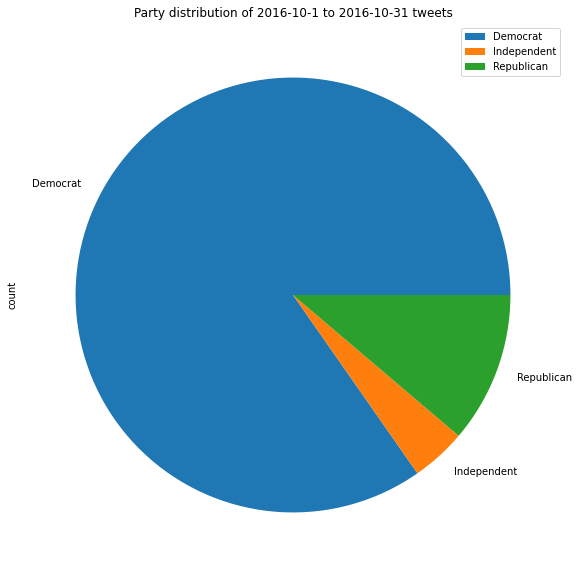

In [25]:
plot_party_dist(in_date, data)